In [1]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc

# Use of RejectionSampler

In [2]:
# before you can use the class, you need all necessary functions like prior, simulator, summaries and observation

In [3]:
def prior_mu(): 
    return np.random.uniform(-2,2) 
 
def prior_sigma(): 
    return np.random.uniform(1,5) 

def simulator(mu, sigma): 
    return np.random.normal(mu, sigma, 30) 

def summary_mean(X): 
    return np.mean(X) 
 
def summary_var(X): 
    return np.var(X) 

In [4]:
#observation 
# Set the generating parameters that we will try to infer 
mean0 = 1 
std0 = 3 

# Generate some data (using a fixed seed here) 
np.random.seed(20170525) 
y0 = simulator(mean0, std0) 

In [5]:
print(y0) 
print(summary_mean(y0)) 
print(summary_var(y0)) 

[ 3.7990926   1.49411834  0.90999905  2.46088006 -0.10696721  0.80490023
  0.7413415  -5.07258261  0.89397268  3.55462229  0.45888389 -3.31930036
 -0.55378741  3.00865492  1.59394854 -3.37065996  5.03883749 -2.73279084
  6.10128027  5.09388631  1.90079255 -1.7161259   3.86821266  0.4963219
  1.64594033 -2.51620566 -0.83601666  2.68225112  2.75598375 -6.02538356]
0.768470010787
8.64433398458


In [6]:
# of course you canno use class without constructor now
try:
    rej = RejectionSampler()
except:
    print("Du darfst das nicht")
    
rej_samp = pyabc.RejectionSampler(priors=[prior_mu, prior_sigma], simulator=simulator, summaries=[summary_var, summary_mean], observation=y0) 


Du darfst das nicht


In [15]:
%time rej_samp.sample(0.5, 500)

Rejection sampler started with threshold: 0.5 and number of samples: 500
Samples:    500 - Threshold: 0.50 - Iterations:      96632 - Time:     5.43 s
CPU times: user 5.43 s, sys: 0 ns, total: 5.43 s
Wall time: 5.43 s


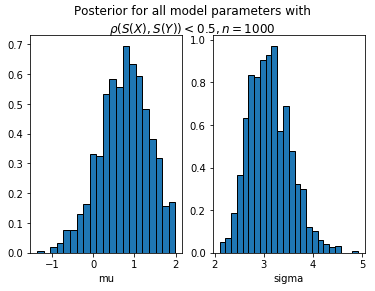

In [8]:
rej_samp.plot_marginals(["mu", "sigma"])

In [9]:
rej_samp.threshold = 1